## Task
Obtain a bunch of leading indicators, which should be highly correlated with UK inflation or UK inflation expectations.


1. Extract the fequency of negative keywords and check the correlations with inflation rate.
2. Craft it more and extract the frequency of the keywords that are related to inflation and check the correlation with inflation rate.
3. Model the keywords (either of all tweets or only that have some keywords) with tf-idf and use the top 10 highest scores keywords to repeat 2.
4. Predict the inflation score using historical data of inflation plus other features extracted from the tweets, for example the frequency of some keywords you indetified from 3.


Last year student: https://github.com/MichelangeloSaveriano/forecasting-inflation-using-tweets


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data
Sample of 844,249 tweets on inflation in the UK for the period 2018-2022. The file has 27 columns.

In [2]:
data = pd.read_parquet('part-00000-64a259cf-ea32-483e-b267-f4a0854c7dc3-c000.snappy.parquet')

In [3]:
data.shape

(844249, 27)

In [4]:
data.columns

Index(['id', 'verb', 'user', 'link', 'body', 'retweetbody', 'date',
       'postedtime', 'retweetcount', 'favoritescount', 'generator',
       'twitter_lang', 'year', 'userLocation', 'userFriends', 'userFollowers',
       'userNumTweets', 'userVerified', 'userLanguage', 'userBio', 'country',
       'countrycode', 'locality', 'region', 'subregion', 'locationname',
       'inreplyto.link'],
      dtype='object')

In [5]:
data['date'].sort_values()

33786     2018-01-01
113785    2018-01-01
117986    2018-01-01
785283    2018-01-01
215226    2018-01-01
             ...    
33781     2022-12-31
33782     2022-12-31
33783     2022-12-31
147534    2022-12-31
299479    2022-12-31
Name: date, Length: 844249, dtype: object

In [6]:
data.iloc[0]

id                                                      -1412257600
verb                                                           post
user                                                     -931661990
link              http://twitter.com/ahlaamomarr/statuses/100070...
body              After successfully making iftar for your whole...
retweetbody                                                    None
date                                                     2018-05-27
postedtime                                 2018-05-27T11:42:52.000Z
retweetcount                                                      0
favoritescount                                                    0
generator                                        Twitter for iPhone
twitter_lang                                                     en
year                                                           2018
userLocation                                        London, England
userFriends                                     

In [7]:
data.iloc[1]

id                                                        531418800
verb                                                          share
user                                                     1115606588
link              http://twitter.com/platypusbanker/statuses/100...
body              RT @BrexitBin: If you still think this is an a...
retweetbody       If you still think this is an acceptable price...
date                                                     2018-05-28
postedtime                                 2018-05-28T14:30:42.000Z
retweetcount                                                     87
favoritescount                                                    0
generator                                        Twitter for iPhone
twitter_lang                                                     en
year                                                           2018
userLocation                                    South East, England
userFriends                                     

### Description
* |-- id: integer (nullable = false) (hashed id)
* |-- verb: string (nullable = true) (can be post or share if a RT)
* |-- user: integer (nullable = false) (hashed user id)
* |-- inreplyto: struct (nullable = true) (in reply to)
    * |-- link: string (nullable = true)
* |-- link: string (nullable = true)
* |-- body: string (nullable = true) (body of tweet)
* |-- retweetbody: string (nullable = true) (body of retweeted tweet)
* |-- date: string (nullable = true) (date)
* |-- postedtime: string (nullable = true) (date and time)
* |-- retweetcount: long (nullable = true) (number of RT)
* |-- favoritescount: long (nullable = true) (number of likes)
* |-- generator: string (nullable = true) (generator)
* |-- twitter_lang: string (nullable = true) (language)
* |-- year: string (nullable = true) (year)
* |-- userLocation: string (nullable = true) (user location)
* |-- userFriends: long (nullable = true) (user friends)
* |-- userFollowers: long (nullable = true) (user followers)
* |-- userNumTweets: long (nullable = true) (number of tweets)
* |-- userVerified: boolean (nullable = true) (verified)
* |-- userLanguage: string (nullable = true) (user language)
* |-- userBio: string (nullable = true) (user bio)
* |-- country: string (nullable = true) (country)
* |-- countrycode: string (nullable = true) (country code)
* |-- locality: string (nullable = true) (locality)
* |-- region: string (nullable = true) (region)
* |-- subregion: string (nullable = true) (sub region)
* |-- locationname: string (nullable = true) (location name)

In [8]:
data['verb'].value_counts()

share    493552
post     350697
Name: verb, dtype: int64

In [9]:
data['link'].value_counts()

http://twitter.com/ahlaamomarr/statuses/1000703881368821760        1
http://twitter.com/lcaller/statuses/1471510670323511299            1
http://twitter.com/Knuckle97716851/statuses/1470762090432503817    1
http://twitter.com/pwayman/statuses/1470795254328664070            1
http://twitter.com/7_StarGirlx/statuses/1470978679782129664        1
                                                                  ..
http://twitter.com/ImaniDH_/statuses/1544630672265994240           1
http://twitter.com/louorns/statuses/1544642295009517569            1
http://twitter.com/DualAspectGlass/statuses/1544682838846472194    1
http://twitter.com/boutiqueheathe1/statuses/1544687877820391424    1
http://twitter.com/Forster06/statuses/999751863745511424           1
Name: link, Length: 844249, dtype: int64

In [10]:
data['generator'].value_counts()

Twitter for iPhone     280860
Twitter for Android    234807
Twitter Web App        165878
Twitter for iPad        47807
Twitter Web Client      26016
                        ...  
BleuPage                    1
troocostJK                  1
ozziapp                     1
ChelseaPro                  1
TweetPoll                   1
Name: generator, Length: 1883, dtype: int64

In [11]:
data['favoritescount'].value_counts()

0    844249
Name: favoritescount, dtype: int64

In [12]:
data['twitter_lang'].value_counts()

en    844249
Name: twitter_lang, dtype: int64

In [13]:
data['userLocation'].value_counts()

London, England              78818
United Kingdom               62627
London                       62299
England, United Kingdom      42198
UK                           39182
                             ...  
Tredegar, Wales, UK              1
woodstock.                       1
the end                          1
Ponteland, Northumberland        1
Sherwood Nottingham              1
Name: userLocation, Length: 28335, dtype: int64

In [14]:
data['userLanguage'].value_counts()

Series([], Name: userLanguage, dtype: int64)

In [15]:
data['userBio'].value_counts()

We are the UK's #1 commission and surcharge free heating oil quote website connecting heating oil consumers with 210+ heating oil suppliers.                           3123
TVCables is part of Nimbus Designs Ltd, established in 1980. We are the best known internet cable retailer in the UK.                                                  2523
Exchange turnip price and make friends with real-time chat!  (Turn on notification time to get latest best prices😉) #AnimalCrossing #TurnipsExchange                   2022
Reporting changes to #FTSE & #AIM shares as well as director trades (#Directortrade). Now showing #Crypto, #Commodities and #Currency exchange rates.                  1602
Photographer - Occasional blogger.\nWhy not LIKE my FB page here: http://t.co/Sj7or8AK My Etsy Shop -  http://t.co/QVi7Xyoxgb                                           791
                                                                                                                                            

In [16]:
data['country'].value_counts()

United Kingdom    844249
Name: country, dtype: int64

In [17]:
data['countrycode'].value_counts()

GB    844249
Name: countrycode, dtype: int64

In [18]:
data['locality'].value_counts()

London            188012
Manchester         20978
Glasgow            14445
South Ockendon     13839
Yorkshire          12848
                   ...  
Meppershall            1
Tintagel               1
Downpatrick            1
Knighton               1
Bampton                1
Name: locality, Length: 2109, dtype: int64

In [19]:
data['region'].value_counts()

England      591164
Scotland      77150
Wales         25761
N Ireland     10415
Name: region, dtype: int64

In [20]:
data['subregion'].value_counts()

Greater London                    206743
City and Borough of Manchester     21129
Essex                              18289
Glasgow City                       14445
City and Borough of Liverpool      12209
                                   ...  
North Down District                    3
Magherafelt District                   3
Ballymoney District                    1
Cookstown District                     1
Dungannon District                     1
Name: subregion, Length: 199, dtype: int64

In [21]:
data['locationname'].value_counts()

London, England, United Kingdom                188012
United Kingdom                                 139759
England, United Kingdom                         72032
Scotland, United Kingdom                        29560
Manchester, England, United Kingdom             20978
                                                ...  
Burtonwood, England, United Kingdom                 1
Chobham, England, United Kingdom                    1
Sutton Bonington, England, United Kingdom           1
Sturminster Newton, England, United Kingdom         1
Bampton, England, United Kingdom                    1
Name: locationname, Length: 2122, dtype: int64

In [22]:
data['inreplyto.link'].value_counts()

http://twitter.com/IsabelOakeshott/statuses/1527199067666784256    28
http://twitter.com/RishiSunak/statuses/1506692275216265219         25
http://twitter.com/DPJHodges/statuses/1592821196495917056          24
http://twitter.com/Conservatives/statuses/1597961261199011840      23
http://twitter.com/DHSCgovuk/statuses/1590723453899898883          16
                                                                   ..
http://twitter.com/GraemeBrogan/statuses/1102714253713309697        1
http://twitter.com/mully1410/statuses/1100379533394526208           1
http://twitter.com/evilblonderobot/statuses/1101961846200983552     1
http://twitter.com/CaliforniaJoe01/statuses/1101397671514959872     1
http://twitter.com/LeopoldHeinrich/statuses/997465650892365824      1
Name: inreplyto.link, Length: 143831, dtype: int64

In [23]:
data.isna().sum()

id                     0
verb                   0
user                   0
link                   0
body                   0
retweetbody       350697
date                   0
postedtime             0
retweetcount           0
favoritescount         0
generator              0
twitter_lang           0
year                   0
userLocation           0
userFriends            0
userFollowers          0
userNumTweets          0
userVerified           0
userLanguage      844249
userBio            78205
country                0
countrycode            0
locality          259078
region            139759
subregion         273556
locationname           0
inreplyto.link    695334
dtype: int64

### Data Assessment
* verb, userVerified: binary
* 'id', 'user', link', 'favoritescount', 'twitter_lang', 'userLanguage', 'country', 'countrycode', 'locationname', 'inreplyto.link': useless
* 'postedtime': datetime
* 'date': datetime

In [24]:
data_cleaned = data.copy(deep=True)

In [25]:
data_cleaned = data_cleaned.drop(columns=['id', 'user', 'favoritescount',
                                          'link', 'twitter_lang', 
                                          'userLanguage', 'country', 
                                          'countrycode', 'locationname', 
                                          'inreplyto.link'])

In [26]:
data_cleaned['verb'] = data_cleaned['verb'].apply(lambda x: 0 if x=='post' else 1)

In [27]:
data_cleaned['userVerified'] = data_cleaned['userVerified'].apply(lambda x: x*1)

In [28]:
data_cleaned['postedtime'] = pd.to_datetime(data_cleaned['postedtime'])
data_cleaned = data_cleaned.sort_values('postedtime')
data_cleaned = data_cleaned.set_index('postedtime')

### Visualizations

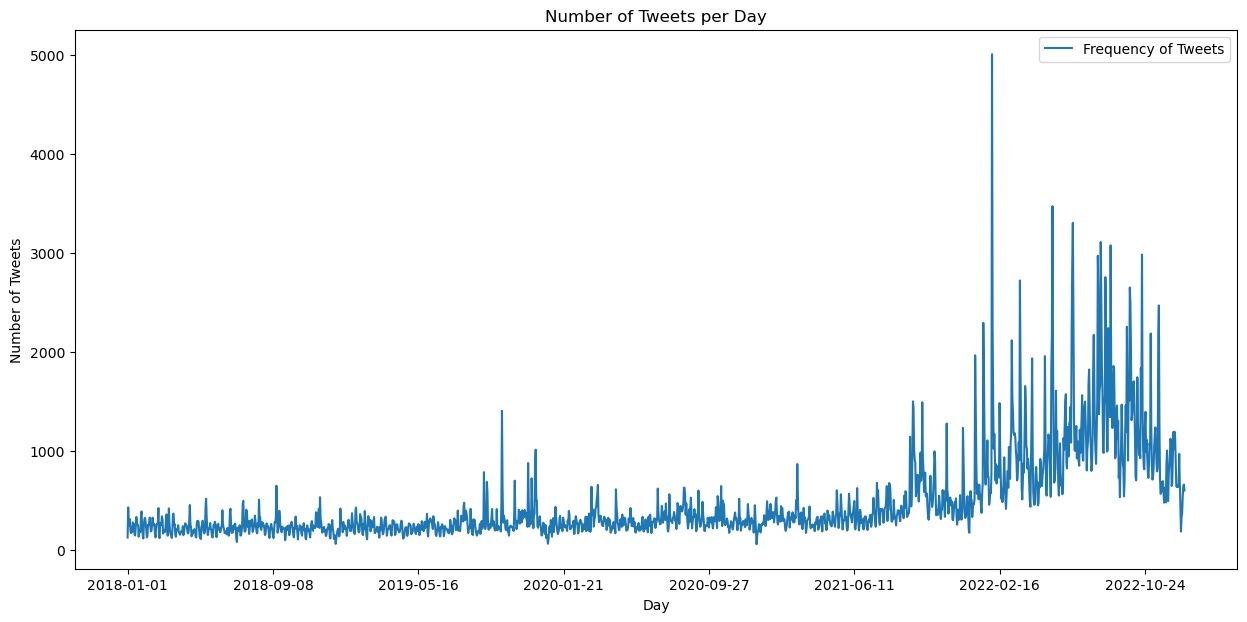

In [29]:
data_cleaned.groupby('date').count()['userNumTweets'].plot(figsize=(15,7))
plt.legend(['Frequency of Tweets'])
plt.xlabel('Day')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets per Day');

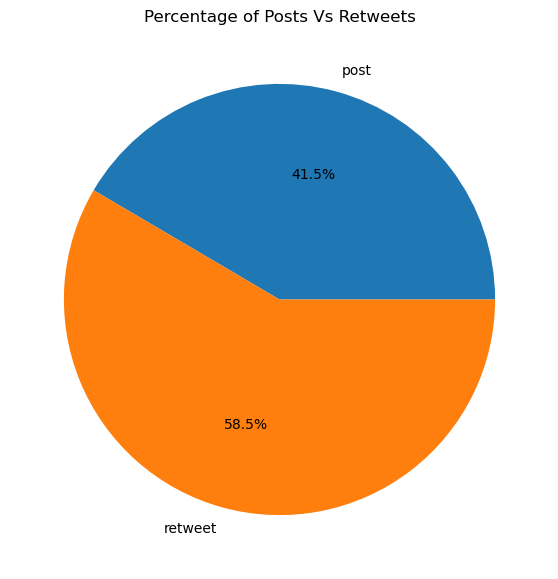

In [30]:
plt.figure(figsize=(7,7))
plt.pie(data_cleaned.groupby('verb').count()['userNumTweets'], labels=['post', 'retweet'], autopct='%1.1f%%')
plt.title('Percentage of Posts Vs Retweets');

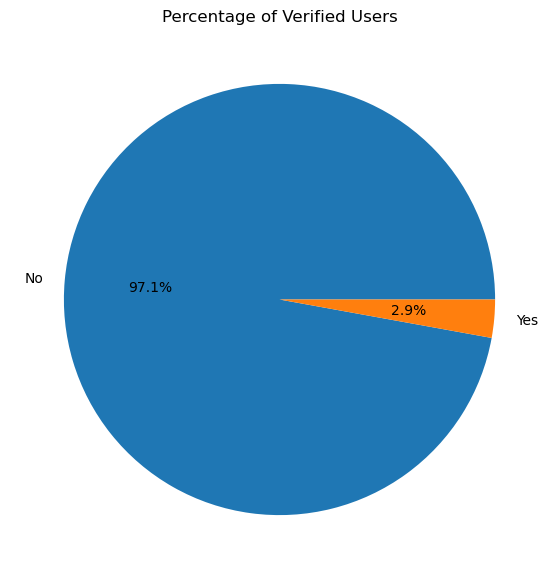

In [33]:
plt.figure(figsize=(7,7))
plt.pie(data_cleaned.groupby('userVerified').count()['userNumTweets'], labels=['No', 'Yes'], autopct='%1.1f%%')
plt.title('Percentage of Verified Users');

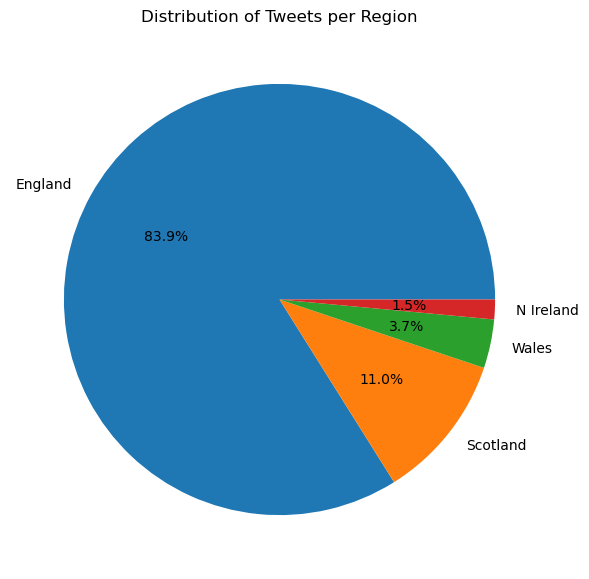

In [34]:
plt.figure(figsize=(7,7))
plt.pie(data_cleaned.region.value_counts().values, 
        labels=data_cleaned.region.value_counts().index, 
        autopct='%1.1f%%'
       )
plt.title('Distribution of Tweets per Region');

''

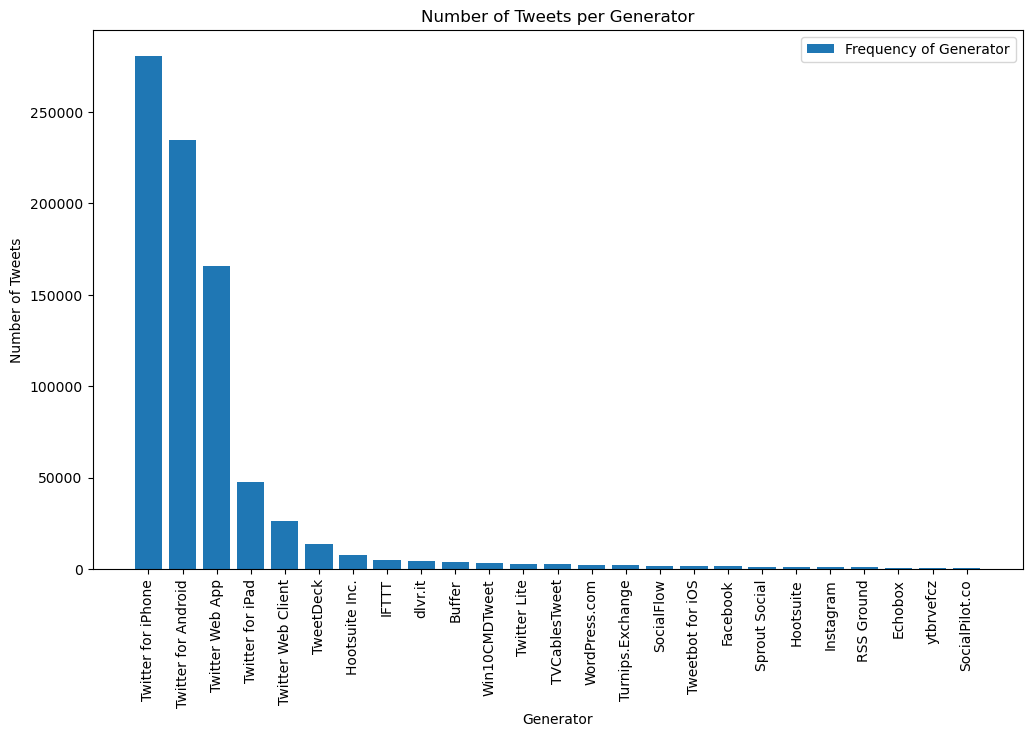

In [35]:
plt.figure(figsize=(12,7))
attribute = data_cleaned.generator.value_counts()[:25]
plt.bar(range(len(attribute)), attribute.values)
plt.xticks(range(len(attribute)), attribute.index, rotation=90)
plt.legend(['Frequency of Generator'])
plt.title('Number of Tweets per Generator')
plt.xlabel('Generator')
plt.ylabel('Number of Tweets')
;

In [36]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import string


# Define stopwords
stop_words = set(stopwords.words('english'))

# Preprocess function
def preprocess_tweet(tweet):
    # Convert to lowercase
    tweet = tweet.lower()
    # Remove urls
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the tweet
    tokens = word_tokenize(tweet)
    # Remove stopwords and stem the words
    ps = PorterStemmer()
    tokens = [ps.stem(token) for token in tokens if token not in stop_words]
    
    processed_text = " ".join(tokens)
    
    return processed_text, tokens

# Apply the preprocessing function to the tweets
data_cleaned[['processed_tweet', 'tweet_tokens']] = data_cleaned['body'].apply(preprocess_tweet).apply(pd.Series)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AhmedOmar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AhmedOmar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [37]:
import pandas as pd
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Function to perform sentiment analysis with a focus on inflation-related tweets
def get_sentiment_with_inflation_context(text):    
    analysis = TextBlob(text)

    # Check for the presence of inflation-related keywords in the tweet
    # Updated list of inflation-related keywords and phrases with Twitter-specific terms
    inflation_keywords = [
        'inflation', 'price increase', 'rising prices', 'monetary policy',
       'central bank', 'CPI', 'consumer price index', 'PPI',
       'producer price index', 'economic growth', 'cost of living',
       'interest rates', 'inflation rate', 'hyperinflation', 'deflation',
       'stagflation', 'inflationary pressures', 'purchasing power',
       'monetary tightening', 'monetary easing', 'quantitative easing',
       'currency devaluation', 'inflation target',
       'inflationary expectations', 'core inflation', 'food inflation',
       'fuel inflation', 'rental inflation', 'wage inflation',
       'imported inflation', 'cost-push inflation',
       'demand-pull inflation', 'structural inflation', 'inflation hedge',
       'inflation risk', 'inflationary environment',
       'inflationary spiral', 'inflation-adjusted', 'inflationary trends',
       'economy', 'growth', 'recession', 'financial crisis', 'market',
       'fed', 'federal reserve', 'economist', 'fiscal policy',
       'monetary stimulus', 'market volatility', 'stock market',
       'unemployment', 'interest rate hike', 'interest rate cut',
       "purchasing managers' index", 'PMI', 'economic indicators',
       'economic outlook', 'inflation expectations', 'economic data',
       'currency', 'economic recovery', 'economic uncertainty',
       'economic analysis', 'economic performance', 'business cycle',
       'economics', 'monetary policy meeting', 'financial markets',
       'global economy', 'economic trends', 'economic forecast',
       'economic news', 'monetary policy decisions', 'economic stimulus',
       'inflation fears', 'economic report', 'central bank action',
       'economic growth rate', 'economic impact', 'economic development',
       'economic conditions', 'econometrics', 'economic models',
       'economics research', 'economic data analysis', 'economic policy',
       'economy news', 'economy analysis', 'economy performance',
       'economy forecast', 'economy data', 'fed meeting',
       'interest rate decisions', 'interest rate changes',
       'monetary policy tools', 'monetary policy actions',
       'interest rate movements', 'federal reserve actions',
       'economist views'
    ]
    inflation_related = any(keyword in text for keyword in inflation_keywords)

    if inflation_related:
        # Calculate sentiment polarity for inflation-related tweets
        polarity = analysis.sentiment.polarity

        # Assign sentiment labels based on the polarity score
        if polarity > 0:
            inflation_sentiment = "Positive"
        elif polarity < 0:
            inflation_sentiment = "Negative"
        else:
            inflation_sentiment = "Neutral"
    else:
        # For tweets not related to inflation, label them as "Not related"
        inflation_sentiment = "Not related to inflation"
        polarity = None
    
    return inflation_sentiment, polarity


# Perform sentiment analysis for each tweet and store the sentiment labels in a new column
data_cleaned[['inflation_sentiment', 'inflation_sentiment_score']] = data_cleaned['processed_tweet'].apply(get_sentiment_with_inflation_context).apply(pd.Series)

In [38]:
data_cleaned_inflation = data_cleaned[~data_cleaned.inflation_sentiment_score.isna()].copy(deep=True)

In [41]:
# data_cleaned_inflation.to_csv('tweets_cleaned_inflation_related.csv')

In [39]:
# List of keywords related to professionals who can talk about inflation
inflation_professionals_keywords = [
    'economist', 'financial analyst', 'central bank economist',
   'macroeconomist', 'monetary policy expert', 'economic researcher',
   'economic consultant', 'inflation analyst', 'financial forecaster',
   'macro analyst', 'market strategist', 'economic journalist',
   'financial reporter', 'economic commentator', 'economic expert',
   'economic professor', 'economic advisor', 'economic policymaker',
   'economic director', 'economic specialist', 'economic writer',
   'economic blogger', 'economic influencer', 'economic speaker',
   'economic educator', 'economic scientisteconomist',
   'economic scientist', 'banking analyst', 'investment analyst',
   'financial economist', 'financial planner', 'financial researcher',
   'economic strategist', 'business economist', 'economic modeler',
   'policy economist', 'government economist', 'academic economist',
   'data economist', 'international economist',
   'fiscal policy analyst', 'financial commentator',
   'investment strategist', 'investment manager',
   'financial consultant', 'financial expert', 'market economist',
   'economic policy analyst', 'economic risk analyst',
   'economic data analyst', 'quantitative economist',
   'financial market analyst', 'economic development specialist',
   'economic planning analyst', 'economic growth analyst',
   'monetary policy researcher', 'economic affairs director',
   'economic indicators analyst', 'economic forecasting analyst',
   'financial markets researcher', 'inflation expectations analyst',
   'economic data researcher', 'economic performance analyst',
   'economic trends analyst', 'economic news reporter',
   'economic data journalist', 'inflation research specialist',
   'economic policy advisor', 'macroeconomic trends analyst',
   'financial markets strategist', 'economic modeling researcher',
   'economic outlook commentator', 'economic trends commentator',
   'economic report analyst', 'economic data expert',
   'inflationary trends researcher', 'economic data forecaster',
   'economic impact consultant', 'economic risk researcher',
   'economic policy specialist', 'financial markets expert',
   'economic commentary writer', 'macroeconomic research specialist',
   'economic development economist', 'economic planning consultant',
   'financial market trends analyst', 'economic indicators expert',
   'economic forecasting specialist', 'economic analysis commentator',
   'economic trends researcher', 'economic news journalist',
   'financial markets commentator',
   'inflation expectations researcher',
   'economic data analysis specialist',
   'economic performance researcher', 'economic policy researcher',
   'economic modeling specialist', 'economic outlook advisor',
   'economic trends specialist', 'economic report researcher',
   'inflation analysis expert', 'macroeconomic trends specialist',
   'monetary economist', 'market analyst', 'portfolio manager',
   'asset manager', 'wealth manager', 'financial advisor',
   'quantitative analyst', 'data analyst', 'financial modeler',
   'risk analyst', 'credit analyst', 'forensic economist',
   'behavioral economist', 'health economist', 'labor economist',
   'environmental economist', 'energy economist',
   'agricultural economist', 'development economist',
   'public finance economist', 'fiscal economist',
   'financial policy expert', 'economic historian',
   'financial historian', 'economic sociologist',
   'economic anthropologist', 'economic geographer',
   'economic demographer', 'economic statistician',
   'economic data scientist', 'financial data scientist',
   'economic futurist', 'financial policy analyst',
   'economic impact analyst', 'economic sustainability expert',
   'economic inequality researcher', 'economic growth specialist',
   'economic trade analyst', 'economic market researcher',
   'economic valuation expert', 'economic regulation specialist',
   'economic reform analyst', 'economic planning expert',
   'economic globalization researcher',
   'economic public relations expert',
   'economic crisis management specialist',
   'economic recovery strategist', 'economic ethics expert',
   'economic behavioral scientist', 'economic cognitive psychologist',
   'economic game theorist', 'economic neuroeconomist',
   'economic decision scientist', 'economic social scientist',
   'economic cultural anthropologist',
   'economic organizational sociologist', 'economic urban geographer',
   'economic rural demographer',
   'economic environmental statistician',
   'economic big data scientist', 'economic climate futurist',
   'economic technology strategist', 'economic AI analyst',
   'economic machine learning specialist',
   'economic blockchain researcher', 'economic cryptocurrency expert',
   'economic sustainable development specialist',
   'economic circular economy analyst', 'economic fintech strategist',
   'economic digital transformation consultant',
   'economic ESG analyst', 'economic impact investing expert',
   'economic green finance consultant',
   'economic regenerative agriculture researcher',
   'economic clean energy specialist',
   'economic social enterprise expert',
   'economic remote work researcher', 'economic gig economy analyst',
   'economic supply chain strategist',
   'economic logistics specialist', 'economic emerging market expert',
   'economic startup advisor', 'economic venture capitalist',
   'economic angel investor', 'economic crowdfunding specialist',
   'economic real estate economist',
   'economic property market analyst',
   'economic housing policy expert',
   'economic transportation economist',
   'economic infrastructure specialist',
   'economic public sector consultant',
   'economic private sector advisor',
   'economic non-profit researcher', 'economic healthcare economist',
   'economic education economist', 'economic trade union strategist',
   'economic financial inclusion expert',
   'economic corporate governance analyst',
   'economic taxation specialist', 'economic tax policy researcher',
   'economic labor market economist', 'economic human capital expert',
   'economic gender equality strategist',
   'economic diversity and inclusion consultant',
   'economic public health specialist',
   'economic mental health economist',
   'economic social welfare researcher',
   'economic public policy analyst',
   'economic sustainable business strategist',
   'economic circular economy expert',
   'economic innovation economist',
   'economic entrepreneurship specialist',
   'economic AI and automation researcher',
   'economic digital economy analyst', 'economic trade policy expert',
   'economic climate change economist',
   'economic disaster recovery specialist',
   'economic conflict resolution analyst',
   'economic peacebuilding expert',
   'economic renewable energy economist',
   'economic climate finance strategist',
   'economic sustainable agriculture researcher',
   'economic natural resource specialist',
   'economic circular economy consultant',
   'economic smart cities analyst', 'economic urban planning expert',
   'economic rural development strategist'
]

# Apply a function to determine if a user is professional
data_cleaned['is_inflationProfessional'] = data_cleaned['userBio'].apply(lambda bio: any(keyword in str(bio).lower() for keyword in inflation_professionals_keywords))

In [49]:
# data_cleaned.to_csv('tweets_cleaned_original.csv', index=True)

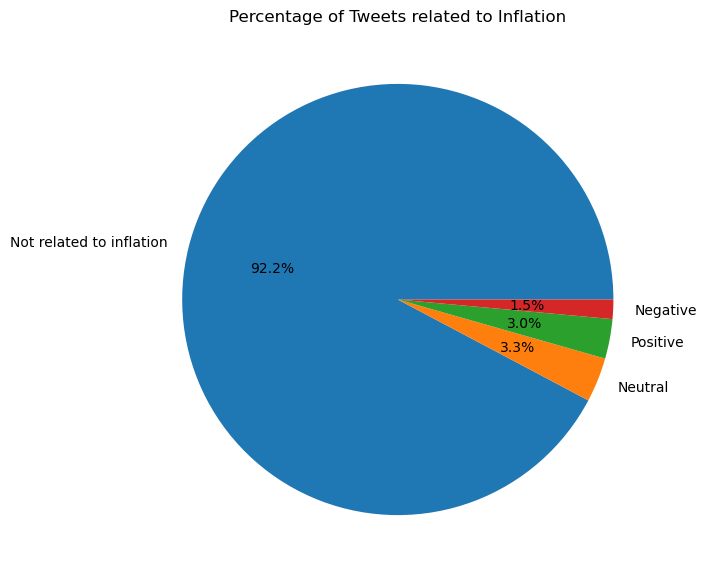

In [42]:
plt.figure(figsize=(7,7))
plt.pie(data_cleaned.inflation_sentiment.value_counts().values, 
        labels=data_cleaned.inflation_sentiment.value_counts().index, 
        autopct='%1.1f%%'
       )
plt.title('Percentage of Tweets related to Inflation');

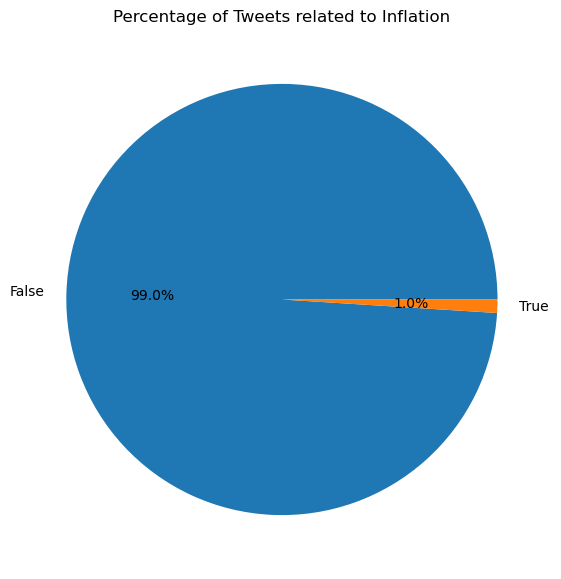

In [43]:
plt.figure(figsize=(7,7))
plt.pie(data_cleaned.is_inflationProfessional.value_counts().values, 
        labels=data_cleaned.is_inflationProfessional.value_counts().index, 
        autopct='%1.1f%%'
       )
plt.title('Percentage of Tweets related to Inflation');

''

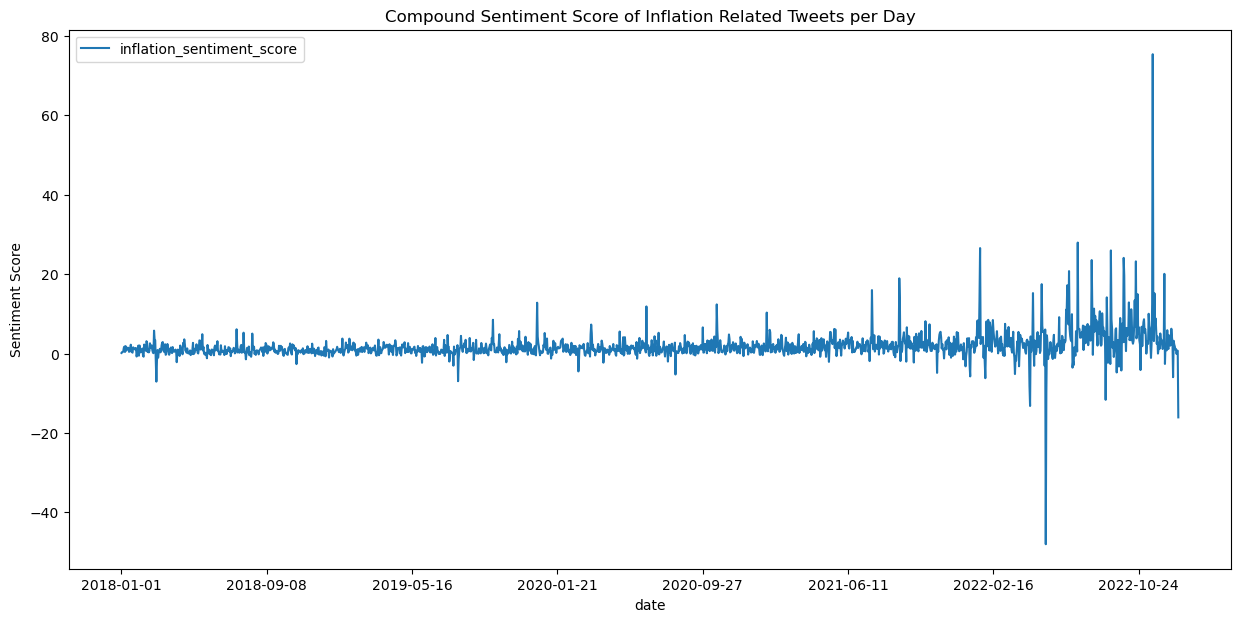

In [88]:
data_cleaned[~data_cleaned['inflation_sentiment'].str.contains('Not related to inflation')].groupby('date').sum()['inflation_sentiment_score'].plot(figsize=(15,7), legend=True);
plt.ylabel('Sentiment Score')
plt.title('Compound Sentiment Score of Inflation Related Tweets per Day')
;

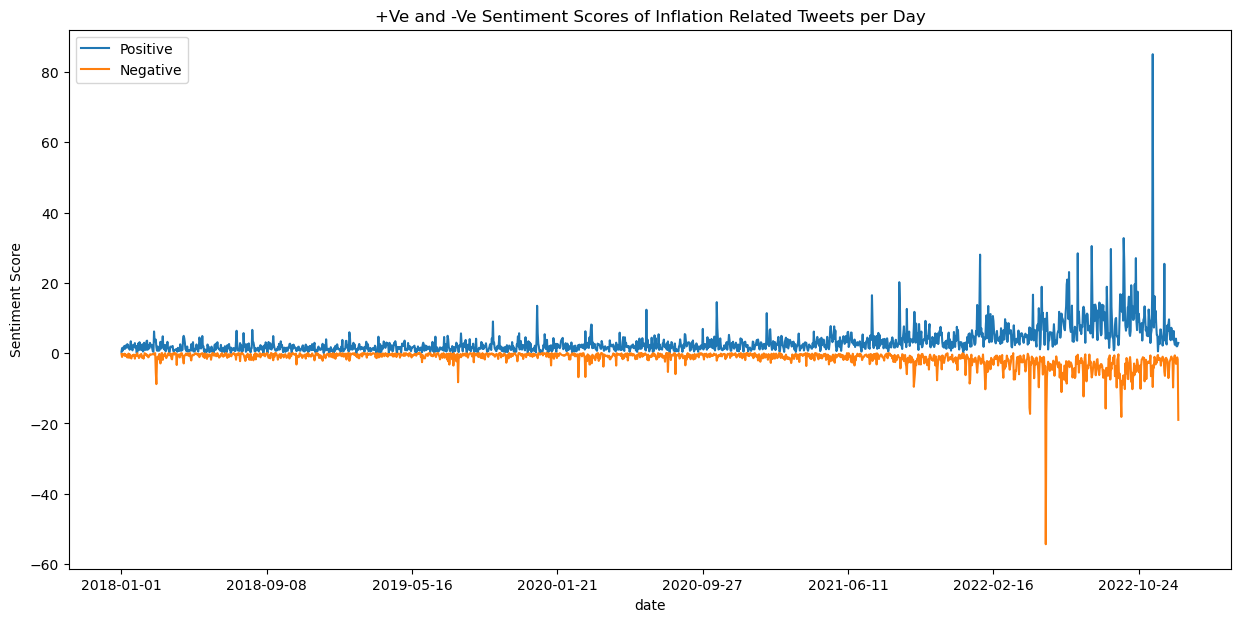

In [87]:
def checkSentiment(x):
    if x['inflation_sentiment'] == 'Positive':
        return x['inflation_sentiment_score'], 0
    if x['inflation_sentiment'] == 'Negative':
        return 0, x['inflation_sentiment_score']
    if x['inflation_sentiment'] == 'Neutral':
        return 0, 0

def printBothSentiment(data):
    dummy = pd.DataFrame()
    dummy['date'] = data['date']
    dummy[['Positive', 'Negative']] = data.apply(lambda x: checkSentiment(x), axis=1).apply(pd.Series)
    dummy.groupby('date').sum().plot(figsize=(15,7))
    plt.ylabel('Sentiment Score')
    plt.title('+Ve and -Ve Sentiment Scores of Inflation Related Tweets per Day')

printBothSentiment(data_cleaned[~data_cleaned['inflation_sentiment'].str.contains('Not related to inflation')])


In [46]:
data_cleaned_prof = data_cleaned[data_cleaned['is_inflationProfessional'] == True].copy(deep=True)

In [47]:
data_cleaned_inflation_prof = data_cleaned_prof[~data_cleaned_prof.inflation_sentiment.str.contains('Not related to inflation')]

In [50]:
inflation_df = pd.DataFrame(index=data_cleaned.date.unique())
inflation_df['countOfInflationTweets'] = data_cleaned[~data_cleaned['inflation_sentiment'].str.contains('Not related to inflation')].groupby('date').count()['inflation_sentiment']
inflation_df['sumOfPositiveInflationSentimentScore'] = data_cleaned[data_cleaned['inflation_sentiment'].str.contains('Positive')].groupby('date').sum()['inflation_sentiment_score']
inflation_df['sumOfNegativeInflationSentimentScore'] = data_cleaned[data_cleaned['inflation_sentiment'].str.contains('Negative')].groupby('date').sum()['inflation_sentiment_score']

''

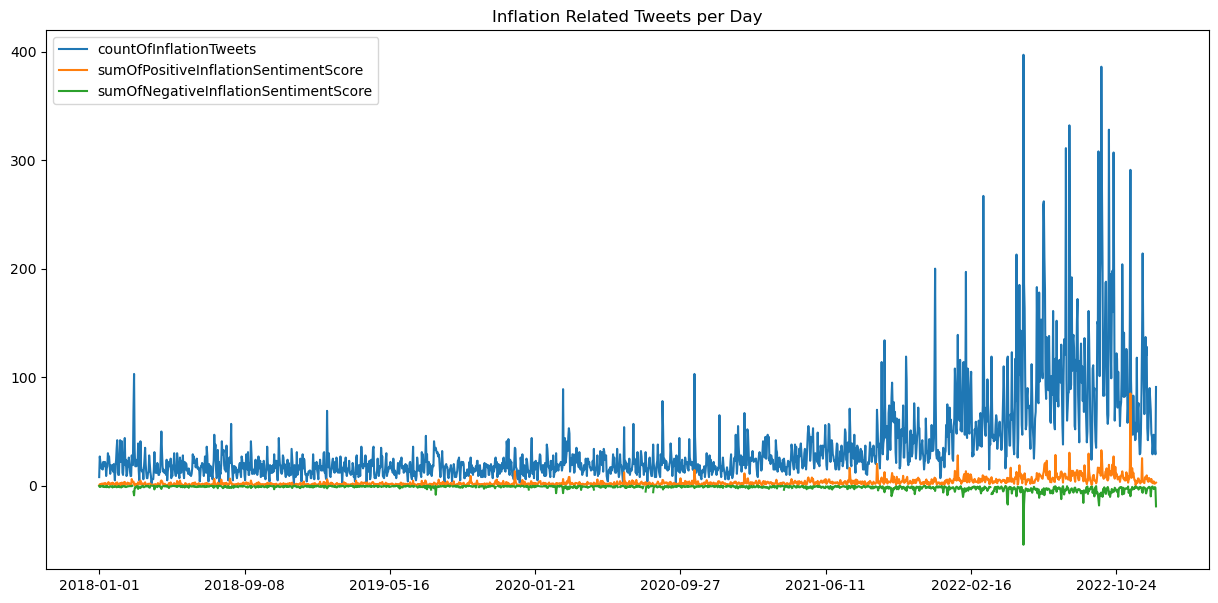

In [54]:
inflation_df.plot(figsize=(15,7))
plt.title('Inflation Related Tweets per Day')
;

In [55]:
inflation_prof_df = pd.DataFrame(index=data_cleaned.date.unique())
inflation_prof_df['countOfInflationTweets'] = data_cleaned_inflation_prof.groupby('date').count()['inflation_sentiment']
inflation_prof_df['sumOfPositiveInflationSentimentScore'] = data_cleaned_inflation_prof[data_cleaned_inflation_prof['inflation_sentiment'].str.contains('Positive')].groupby('date').sum()['inflation_sentiment_score']
inflation_prof_df['sumOfNegativeInflationSentimentScore'] = data_cleaned_inflation_prof[data_cleaned_inflation_prof['inflation_sentiment'].str.contains('Negative')].groupby('date').sum()['inflation_sentiment_score']
inflation_prof_df = inflation_prof_df.fillna(0)

''

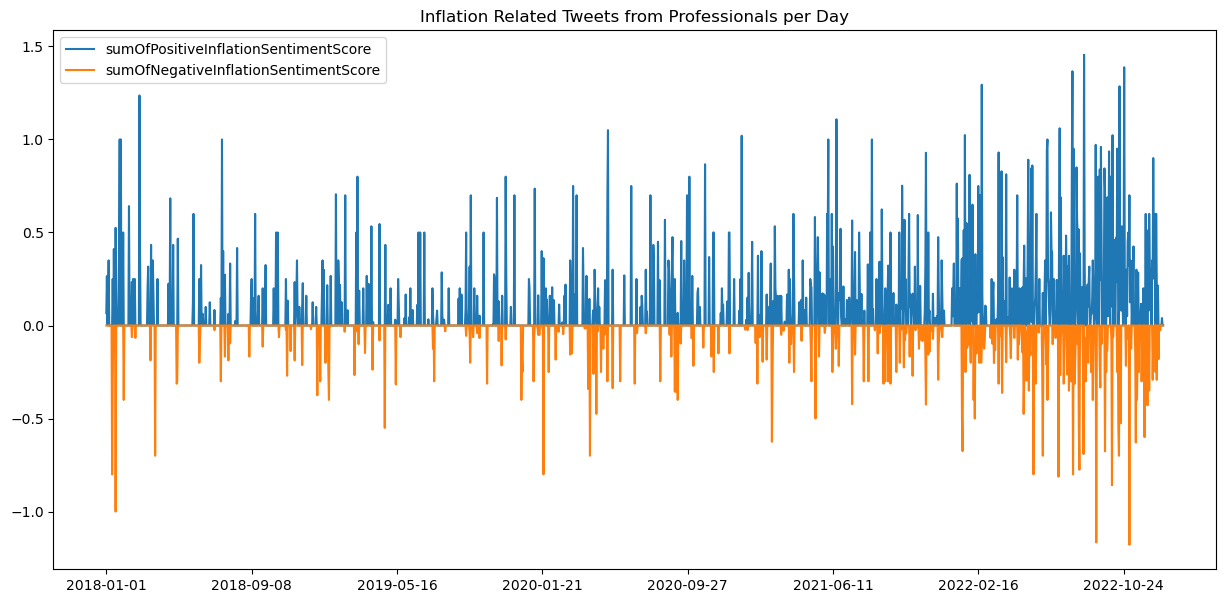

In [56]:
inflation_prof_df.drop(columns='countOfInflationTweets').plot(figsize=(15,7))
plt.title('Inflation Related Tweets from Professionals per Day')
;

In [57]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine the processed tweets into a single string
combined_tweets = ' '.join(data['processed_tweet'].astype(str))

# Generate a word cloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(combined_tweets)

# Display the generated wordcloud:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

KeyError: 'processed_tweet'

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine the processed tweets into a single string
combined_tweets = ' '.join(data_cleaned['processed_tweet'].astype(str))

# Generate a word cloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(combined_tweets)

# Display the generated wordcloud:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

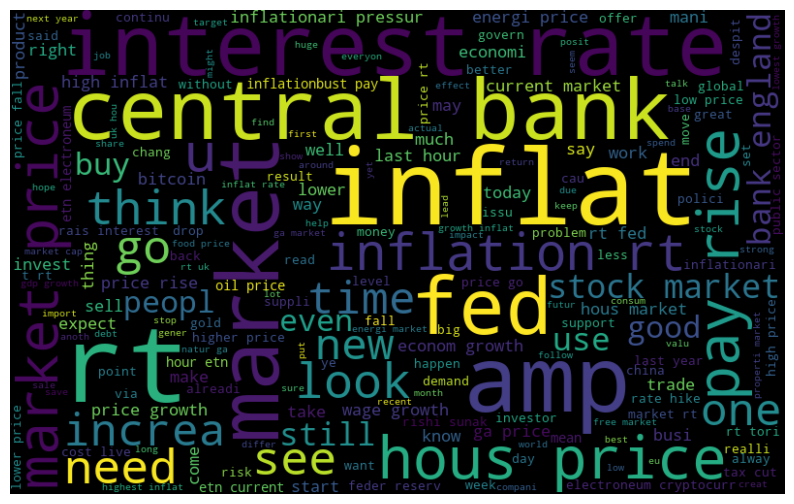

In [58]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine the processed tweets into a single string
combined_tweets = ' '.join(data_cleaned_inflation['processed_tweet'].astype(str))

# Generate a word cloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(combined_tweets)

# Display the generated wordcloud:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

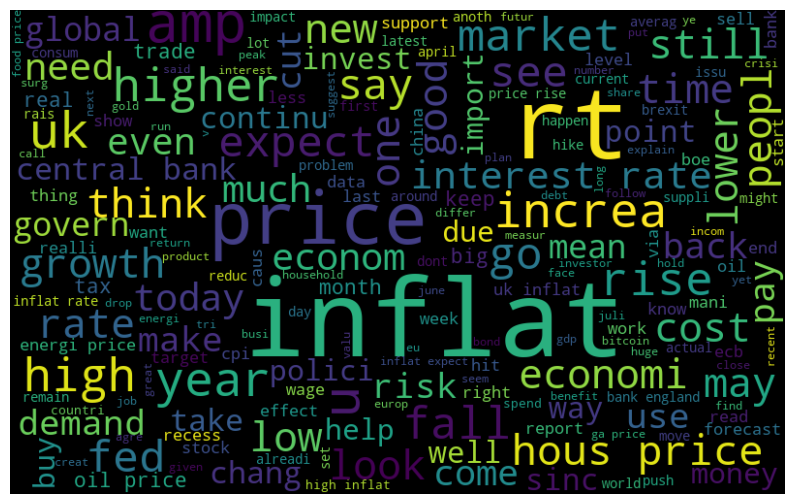

In [59]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine the processed tweets into a single string
combined_tweets = ' '.join(data_cleaned_prof['processed_tweet'].astype(str))

# Generate a word cloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(combined_tweets)

# Display the generated wordcloud:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

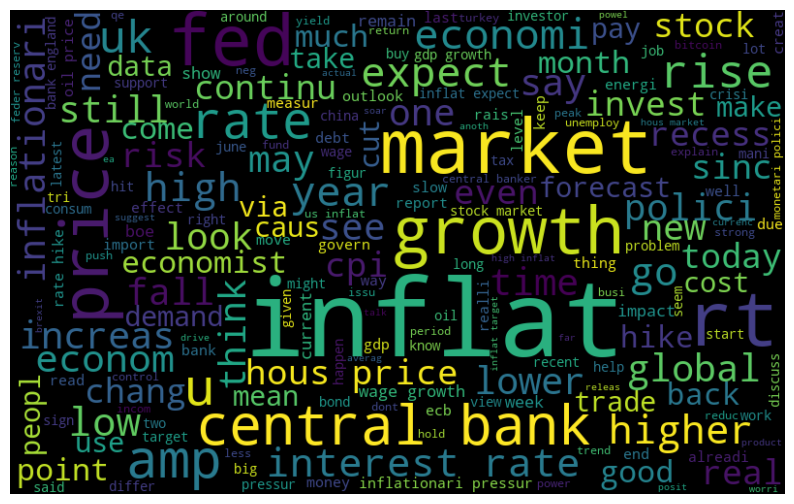

In [60]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine the processed tweets into a single string
combined_tweets = ' '.join(data_cleaned_inflation_prof['processed_tweet'].astype(str))

# Generate a word cloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(combined_tweets)

# Display the generated wordcloud:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
'CPHPTT01GBM659N.csv'
'GBRCPALTT01CTGYM.csv'
'GBRCPIALLMINMEI.csv'
'GBRCPIENGMINMEI.csv'

# Previous Work

## Unigrams Distribution

NameError: name 'sns' is not defined

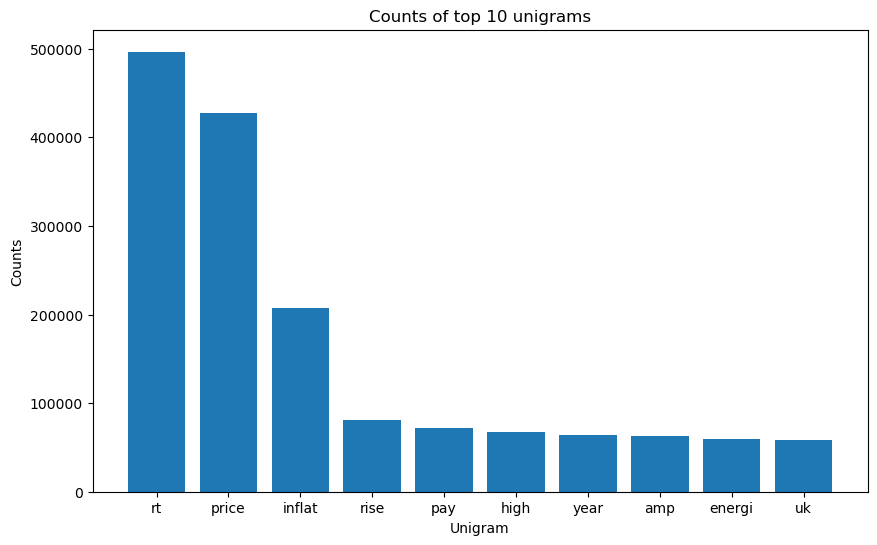

In [66]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
def get_top_n_words(corpus, n=None):
  vec = CountVectorizer(stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]
common_words = get_top_n_words(data_cleaned['processed_tweet'] , 10)
unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])


plt.figure(figsize=(10,6))
plt.bar(x = unigram['unigram'], height = unigram['count'] )
plt.title('Counts of top 10 unigrams')
plt.ylabel('Counts')
plt.xlabel('Unigram')
sns.despine();

Text(0.5, 0, 'Unigram')

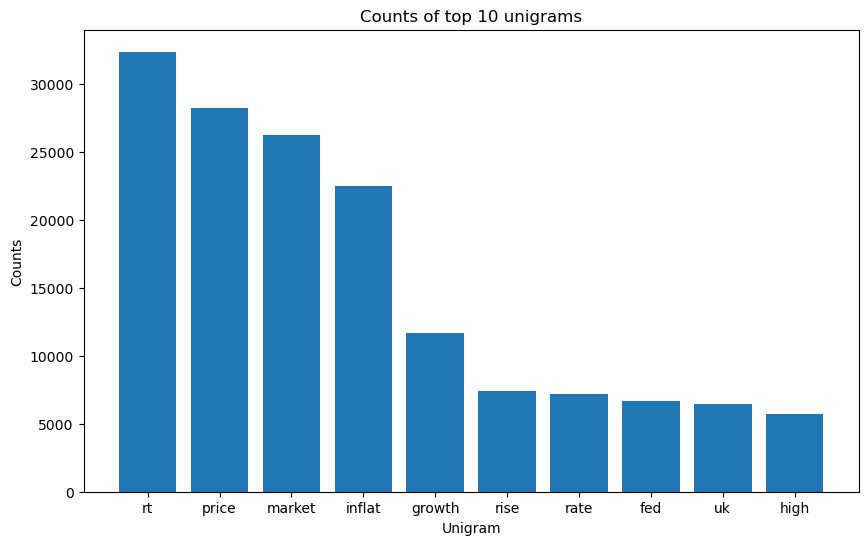

In [67]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
def get_top_n_words(corpus, n=None):
  vec = CountVectorizer(stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]
common_words = get_top_n_words(data_cleaned_inflation['processed_tweet'] , 10)
unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])


plt.figure(figsize=(10,6))
plt.bar(x = unigram['unigram'], height = unigram['count'] )
plt.title('Counts of top 10 unigrams')
plt.ylabel('Counts')
plt.xlabel('Unigram')
# sns.despine();

## Trigram Distribution

In [68]:
def get_top_n_trigram(corpus, n=None):
  vec = CountVectorizer(ngram_range=(3,3),stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in      vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]
common_words = get_top_n_trigram(data_cleaned_inflation['processed_tweet'], 10)
trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

NameError: name 'sns' is not defined

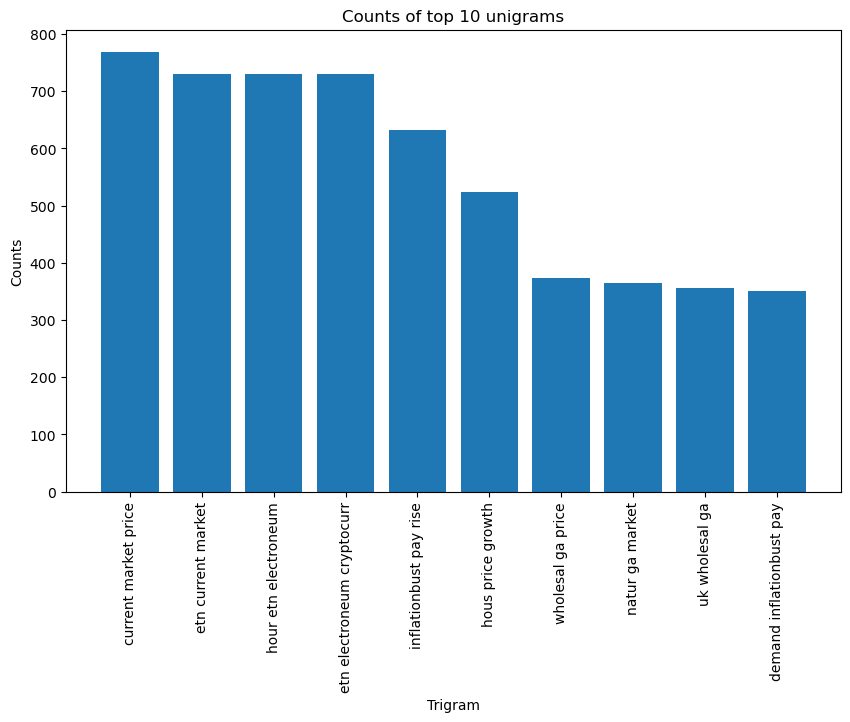

In [69]:
plt.figure(figsize=(10,6))

plt.bar(x = trigram['trigram'], height = trigram['count'] )

plt.title('Counts of top 10 unigrams')
plt.ylabel('Counts')
plt.xlabel('Trigram')
plt.xticks(rotation=90)

sns.despine();

## LDA

In [70]:
from sklearn.decomposition import LatentDirichletAllocation
vectorizer = CountVectorizer(
analyzer='word',       
min_df=3,# minimum required occurences of a word 
stop_words='english',# remove stop words
max_features=5000,# max number of unique words
                            )
data_matrix = vectorizer.fit_transform(data_cleaned_inflation['processed_tweet'])
data_matrix

<65444x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 858026 stored elements in Compressed Sparse Row format>

In [71]:

vectorizer = CountVectorizer(
analyzer='word',       
min_df=3,# minimum required occurences of a word 
max_features=5000,# max number of unique words
                            )
data_matrix = vectorizer.fit_transform(data_cleaned_inflation['processed_tweet'])
data_matrix

<65444x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 938864 stored elements in Compressed Sparse Row format>

In [72]:
lda_model = LatentDirichletAllocation(
  n_components=10, # Number of topics
  learning_method='online',
  random_state=20,       
  n_jobs = -1  # Use all available CPUs
)
lda_output = lda_model.fit_transform(data_matrix)

In [73]:
for i,topic in enumerate(lda_model.components_):
  print(f'Top 10 words for topic #{i}:')
  print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
  print('\n')

Top 10 words for topic #0:
['right', 'buy', 'make', 'invest', 'inflationbust', 'need', 'profit', 'get', 'price', 'market']


Top 10 words for topic #1:
['could', 'year', 'want', 'rise', 'growth', 'uk', 'pay', 'energi', 'inflat', 'rt']


Top 10 words for topic #2:
['broken', 'say', 'warn', 'rishi', 'food', 'said', 'sunak', 'rt', 'supermarket', 'price']


Top 10 words for topic #3:
['etn', 'fund', 'reserv', 'year', 'price', 'next', 'current', 'last', 'market', 'us']


Top 10 words for topic #4:
['oil', 'growth', 'high', 'suppli', 'fall', 'rt', 'uk', 'hous', 'market', 'price']


Top 10 words for topic #5:
['world', 'economist', 'recess', 'tori', 'rise', 'econom', 'wage', 'inflat', 'rt', 'growth']


Top 10 words for topic #6:


C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['say', 'come', 'rais', 'central', 'interest', 'rt', 'bank', 'fed', 'rate', 'inflat']


Top 10 words for topic #7:
['run', 'think', 'better', 'huge', 'amp', 'well', 'ga', 'inflation', 'go', 'rt']


Top 10 words for topic #8:
['low', 'would', 'money', 'tax', 'cut', 'rt', 'price', 'market', 'inflationari', 'cost']


Top 10 words for topic #9:
['gold', 'rt', 'risk', 'market', 'sector', 'worker', 'bitcoin', 'rise', 'inflationari', 'pay']




In [74]:
lda_model.components_

array([[ 0.10001625,  0.100016  ,  0.10000467, ...,  0.10002603,
         0.10003003, 42.66160547],
       [16.41647963,  0.10000519,  0.10000341, ..., 87.83395605,
         0.10001495,  0.10000246],
       [ 0.1000072 ,  0.10000532,  0.10000216, ...,  0.10001587,
         0.10001917,  0.10000879],
       ...,
       [ 0.10001317,  0.10000484,  0.1       , ...,  0.10001284,
         0.10001393,  0.10000034],
       [ 0.10002224,  0.10000972,  0.10000062, ...,  0.10002143,
         0.10002639,  0.10001242],
       [ 0.10004751,  0.10000833,  0.10000528, ...,  0.1000244 ,
         0.10016998,  0.10000196]])

In [76]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_matrix, vectorizer, mds='tsne')

C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\AhmedOmar\anaconda3\envs\dde\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
C:\Users\AhmedOmar\anaconda3\env

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4      32.420952   8.115230       1        1  17.132418
6       0.648955  71.707100       2        1  16.016460
8      71.019684   9.971006       3        1  13.320123
1       3.785981  33.185135       4        1  12.871749
5     -42.666500  -9.222070       5        1   8.845840
7      -3.621689 -43.526516       6        1   8.174906
0      -3.632402  -4.171708       7        1   7.482803
9     -36.584400  35.804413       8        1   6.180769
2      44.391380  50.615383       9        1   6.010801
3      40.235809 -31.591665      10        1   3.964131, topic_info=        Term          Freq         Total Category  logprob  loglift
2352  inflat  22535.000000  22535.000000  Default  30.0000  30.0000
3456   price  26373.000000  26373.000000  Default  29.0000  29.0000
2772  market  25200.000000  25200.000000  Default  28.0000  28.0000
2097  growth  11410.000000  11410.000000  Default  27.0000  27.0000
4715      us   5106.000000   5106.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
22        10    658.150340   1135.348675  Topic10  -4.0915   2.6826
4964    year   1507.317721   5925.086549  Topic10  -3.2628   1.8590
2772  market   2592.529707  25200.404549  Topic10  -2.7205   0.9537
3456   price   1872.181478  26373.575736  Topic10  -3.0461   0.5826
1451  dollar    359.368075    718.773650  Topic10  -4.6966   2.5347

[483 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
22        3  0.419254     10
22       10  0.579558     10
30       10  0.998103    101
44       10  0.996525    111
61       10  0.997543     14
...     ...       ...    ...
4964      7  0.000506   year
4964     10  0.254342   year
4974      4  0.999161    yet
4975      2  0.997852  yield
4984      5  0.997086   your

[603 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 9, 2, 6, 8, 1, 10, 3, 4])

# Indices

## Vader

In [79]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
scores = data_cleaned['body'].apply(lambda review: sid.polarity_scores(review))
df_vader_scores = pd.DataFrame(scores.values.tolist())

pkl_save('vader_scores', df_vader_scores)

df_vader_scores = pkl_load('vader_scores')

In [80]:
df_day = pd.DataFrame()
single_dates = data_cleaned['date'].unique()
df_day['date'] = single_dates
df_day['year_month'] = [date[:7]  for date in single_dates]
df_day['day'] = [ date[8:] for date in single_dates]
df_day['month'] = [ date[5:7] for date in single_dates]
df_day['year'] = [ date[:4] for date in single_dates]
df_day = df_day.sort_values('date').reset_index(drop=True)

In [81]:
data_cleaned['year_month'] = [date[:7]  for date in data_cleaned['date']]

In [95]:
def aggregate_signal(signal_matrix, df_time, agg_columns):
  l = []
  for date, group in df_time.groupby(agg_columns):
    means_row = np.mean(signal_matrix[group.index], axis = 0)
    l+= [means_row]
  return np.vstack(l)

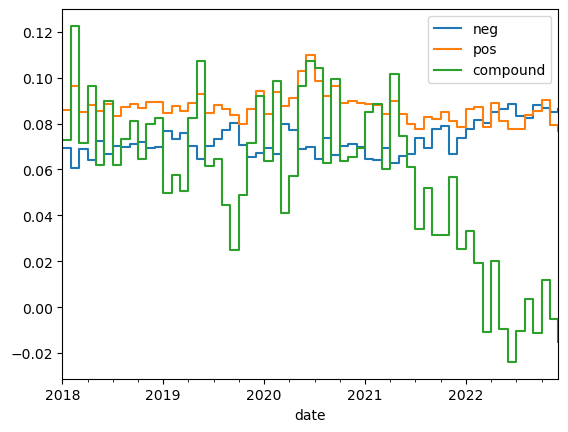

In [96]:
daily_vader = aggregate_signal(df_vader_scores.values, data_cleaned.reset_index(), 'date')


df_monthly_vader = pd.DataFrame(aggregate_signal(daily_vader, df_day, 'year_month'),
                               columns = df_vader_scores.columns)

df_monthly_vader['date'] = pd.to_datetime(df_day['year_month'].unique() + '-01')
df_monthly_vader.drop(columns='neu').plot(x='date', drawstyle="steps-post")
plt.show()

## TF

In [97]:
vectorizer = TfidfVectorizer(min_df=0.002,  ngram_range=(2, 3), norm='l1', use_idf=False)
tf_embedding = vectorizer.fit_transform(data_cleaned['date'])
vocabulary = vectorizer.vocabulary_

tf_embedding = pkl_load('tf_scores')
vocabulary = pkl_load('tf_vocabulary')

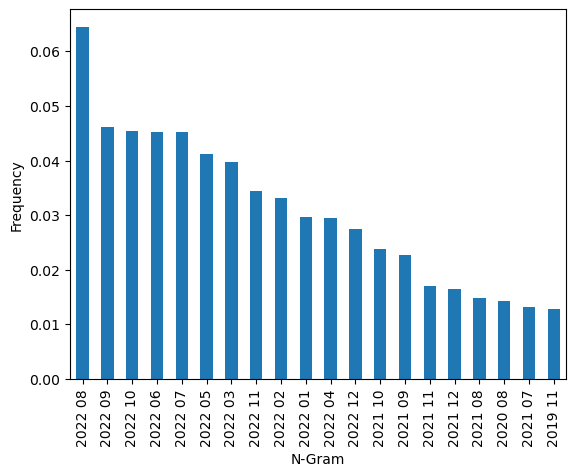

In [101]:
# matplotlib.rc('xtick', labelsize=17) 
# matplotlib.rc('ytick', labelsize=17) 
word_freq = pd.DataFrame({'word': vocabulary.keys(), 'id': vocabulary.values()}).sort_values('id', ascending=True).reset_index(drop=True)
word_freq['df'] = np.array((tf_embedding > 0).mean(axis=0))[0]
ax = word_freq.sort_values('df', ascending=False).iloc[:20].plot.bar(x='word', y = 'df')
ax.get_legend().remove()
ax.set_xlabel('N-Gram')
ax.set_ylabel('Frequency')

plt.show()

## Bert

In [102]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-distilroberta-v1')

In [103]:
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

#Sentences we want to encode. Example:
sentence = ['This framework generates embeddings for each input sentence']


#Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)

In [105]:
embedding.shape

(1, 768)

In [106]:
df_body_day = ['. '.join(group['body']) for date, group in data_cleaned.groupby('date')]
df_inflation_body_day = ['. '.join(group['body']) for date, group in data_cleaned_inflation.groupby('date')]
df_professionals_body_day = ['. '.join(group['body']) for date, group in data_cleaned_prof.groupby('date')]
df_professionals_inflation_body_day = ['. '.join(group['body']) for date, group in data_cleaned_inflation_prof.groupby('date')]

In [ ]:
day_agg_bert = model.encode(df_body_day, batch_size = 250, show_progress_bar = True)
day_agg_bert_inflation = model.encode(df_inflation_body_day, batch_size = 250, show_progress_bar = True)
day_agg_bert_professionals = model.encode(df_professionals_body_day, batch_size = 250, show_progress_bar = True)
day_agg_bert_professionals_inflation = model.encode(df_professionals_inflation_body_day, batch_size = 250, show_progress_bar = True)

Batches:   0%|          | 0/8 [00:00<?, ?it/s]